## CSC 395 Final Project: Code
#### Dylan Laurianti, Yilan Dong
This file consists of four parts:
1. Implementations of SVD algorithms:  
    a. general SVD (named mySVD),  
    b. thin SVD (myThinSVD),  
    c. compact SVD (myCompactSVD) and  
    d. truncated SVD (myTruncatedSVD);
2. Test cases for all implementations;
3. Time efficiency analysis and corresponding graphs;
4. Past approaches to SVD that does not yield correct result, commented out.

You can run all parts by restarting the kernel, or specific cells, by selecting and running them one at a time.

In [1]:
# Preperations; required packages and global variable
using LinearAlgebra
using TSVD
using Test
using Plots
using LightGraphs
gr()
# chosen due to the limited computation power of our machines
max_size = 500; 

## Implementations

#### General SVD

In [2]:
#=
Procedure: mySVD
Parameters: A, an mxn matrix; cutNum, an optional parameter indicating the rank needing to be computed
Purpose: Applies a general purpose SVD algorithm to calculate the SVD factorization of A
         This general implementation can apply all 3 SVD reduction methods, but less efficiently
         (Only saves on the calculations of singVec_U)
Produces: singVec_U, a mxn matrix containing the left singular vectors of A; 
          sigma, an array containing n non-decreasing singular values of A;
          singVec_V, a nxn matrix containing the right singular vectors of A
Preconditions: A's eigenvalues are real numbers; 0 < cutNum <= n
Postconditions: A ≈ singVec_U * Diagonal(sigma) * singVec_V'
=#
function mySVD(A, cutNum=-1)
    m, n = size(A)
    tall = true
    
    if (n > m)
        tall = false
        A = A'
        m, n = size(A)
    end

    # Compute singular values and vectors for V
    sigma, singVec_V = eigen(A' * A)
    # Does not work on complex eigen values
    # Calculate the squareroot of the eigenvalues of the A'A matrix, which are the eigenvalues of A
    sigma = broadcast((x -> sqrt(abs(x))), sigma)
    # Sort singVec_V and sigma so the eigenvalues are in descending order
    singVec_V = singVec_V[:, sortperm(sigma, rev=true)]
    sort!(sigma, rev=true)


    # Compute the rank
    if cutNum == -1
        # compute the nonzero singular values
        sig_rank = size(filter((x -> x != 0), sigma), 1)
    else
        sig_rank = cutNum
    end

    # Compact the sigma matrix to only represent those non-zero singular values
    # Or, if cutNum is specified, to only represent the cutNum largest singular values
    sigma = sigma[1:sig_rank]

    # Compute left singular vectors
    # Initializing the left singular vector
    singVec_U = Array{Float64}(undef, m, sig_rank)
        
    # Compute the left singular vector
    for i in 1:sig_rank
        # Compute AV_i
        temp_A = A * singVec_V[:, i]
        # Normalize AV_i
        temp_A_normal = temp_A / sigma[i]
        singVec_U[:,i] = temp_A_normal'
    end
    # If the matrix was not tall, we need to revert the transpose done at the start of the algorithm
    if !tall
        return singVec_V, sigma, singVec_U
    else
        return singVec_U, sigma, singVec_V
    end
end

mySVD (generic function with 2 methods)

#### Thin SVD

In [3]:
#=
Procedure: myThinSVD
Parameters: A, a mxn tall and skinny matrix
Purpose: Applies a reduced SVD algorithm to calculate the SVD factorization of A
Produces: singVec_U, a mxn matrix containing the left singular vectors of A; 
          sigma, an array containing n non-decreasing singular values of A;
          singVec_V, a nxn matrix containing the right singular vectors of A
Preconditions: A's eigenvalues are real numbers, m > n
Postconditions: A ≈ singVec_U * Diagonal(sigma) * singVec_V'
=#
function myThinSVD(A)
    m, n = size(A)
    
    # Check if A is tall and skinny
    if (n > m)
        throw(ArgumentError(A, "Matrix must be tall."))
    end

    # Compute singular values and vectors for V
    sigma, singVec_V = eigen(A' * A)
    # Does not work on complex eigen values
    # Calculate the squareroot of the eigenvalues of the A'A matrix, which are the eigenvalues of A
    sigma = broadcast((x -> sqrt(abs(x))), sigma)
    # Sort singVec_V and sigma so the eigenvalues are in descending order
    singVec_V = singVec_V[:, sortperm(sigma, rev=true)]
    sigma = sort(sigma, rev=true)
    sig_rank = size(sigma, 1)
    
    # Compute left singular vectors
    # Initializing the left singular vector
    singVec_U = Array{Float64}(undef, m, sig_rank)
        
    # Compute the left singular vector
    for i in 1:sig_rank
        # Compute AV_i
        temp_A = A * singVec_V[:, i]
        # Normalize AV_i
        temp_A_normal = temp_A / sigma[i]
        singVec_U[:,i] = temp_A_normal'
    end
    return singVec_U, sigma, singVec_V
end

myThinSVD (generic function with 1 method)

#### Compact SVD 

In [4]:
#=
Procedure: myCompactSVD
Parameters: A, a mxn tall and skinny matrix with rank r
Purpose: Applies a reduced SVD algorithm to calculate the SVD factorization of A
Produces: singVec_U, a mxr matrix containing the left singular vectors of A; 
          sigma, an array containing r non-decreasing, non-zero singular values of A;
          singVec_V, a rxn matrix containing the right singular vectors of A
Preconditions: A's eigenvalues are real numbers, m > n
Postconditions: A ≈ singVec_U * Diagonal(sigma) * singVec_V'
=#
function myCompactSVD(A)
    m, n = size(A)
        
    if (n > m)
        throw(ArgumentError(A, "Matrix must be tall."))
    end

    # Compute singular values
    sigma = eigvals(A' * A)
    
    # Remove the zero singular values
    for s in sigma
        if s ≈ 0
            pop!(sigma, s)
        end
    end
    
    # Calculate r
    sig_rank = size(filter((x -> x != 0), sigma), 1)
    
    # Compute the singular vectors corresponding to the non-zero singular values
    Q, H = hessenberg(Symmetric(A' * A))
    singVec_V = Q*eigvecs(H, sigma)
    
    # Does not work on complex eigen values
    # Calculate the squareroot of the eigenvalues of the A'A matrix, which are the eigenvalues of A
    sigma = broadcast((x -> sqrt(abs(x))), sigma)
    # Sort singVec_V and sigma so the eigenvalues are in descending order
    singVec_V = singVec_V[:, sortperm(sigma, rev=true)]
    sort!(sigma, rev=true)

    # Compute left singular vectors
    # Initializing the left singular vector
    singVec_U = Array{Float64}(undef, m, sig_rank)
        
    # Compute the left singular vector
    for i in 1:sig_rank
        # Compute AV_i
        temp_A = A * singVec_V[:, i]
        # Normalize AV_i
        temp_A_normal = temp_A / sigma[i]
        singVec_U[:,i] = temp_A_normal'
    end
    return singVec_U, sigma, singVec_V
end

myCompactSVD (generic function with 1 method)

#### Truncated SVD

In [19]:
#=
Procedure: myTruncatedSVD
Parameters: A, an mxn matrix; t, the number of singular values to return
Purpose: Applies a reduced SVD algorithm to calculate the SVD factorization of A
Produces: singVec_U, a mxt matrix containing the t most important left singular vectors of A; 
          sigma, an array containing the t greatest non-decreasing singular values of A;
          singVec_V, a txn matrix containing the right singular vectors of A
Preconditions: A's eigenvalues are real numbers, m > n
Postconditions: singVec_U * Diagonal(sigma) * singVec_V' is the best rank t approximation of A
=#
function myTruncatedSVD(A, t)
    m, n = size(A)
        
    if (n > m)
        throw(ArgumentError(A, "Matrix must be tall."))
    end

    # Compute t singular values
    Q, H = hessenberg(Symmetric(A' * A))
    sigma, singVec_V = eigen(H, n-t+1:n)
    singVec_V = Q*singVec_V
    
    
    # Calculate r
    sig_rank = size(filter((x -> x != 0), sigma), 1)
    
    # Does not work on complex eigen values
    # Calculate the squareroot of the eigenvalues of the A'A matrix, which are the eigenvalues of A
    sigma = broadcast((x -> sqrt(abs(x))), sigma)
    # Sort singVec_V and sigma so the eigenvalues are in descending order
    singVec_V = singVec_V[:, sortperm(sigma, rev=true)]
    sort!(sigma, rev=true)

    # Compute left singular vectors
    # Initializing the left singular vector
    singVec_U = Array{Float64}(undef, m, sig_rank)
        
    # Compute the left singular vector
    for i in 1:sig_rank
        # Compute AV_i
        temp_A = A * singVec_V[:, i]
        # Normalize AV_i
        temp_A_normal = temp_A / sigma[i]
        singVec_U[:,i] = temp_A_normal'
    end
    return singVec_U, sigma, singVec_V
end

myTruncatedSVD (generic function with 1 method)

### Tests

#### Helper Functions

In [6]:
#=
Procedure: absColumnEquals
Parameters: A, an mxn matrix; B, an mxn matrix
Purpose: For i in 1:n, compares A[i] and B[i]
Produces: true, if for all i, A[i] == B[i] or A[i] == -B[i]; false otherwise
Preconditions: A and B are of the same size
Postconditions: No additional
=#
function absColumnEquals(A, B)
    for i in 1:size(A,1)
        if (A[i] ≈ B[i]) || (A[i] ≈ -B[i])
            continue
        else
            return false
        end
    end
    return true
end

absColumnEquals (generic function with 1 method)

In [7]:
#=
Procedure: truncatedSVD
Parameters: A, an mxn matrix; t, the number of singular values to return
Purpose: Applies a reduced SVD algorithm to calculate the SVD factorization of A
         Implemented using the built-in svd algorithm from linearAlgebra.jl
Produces: singVec_U, a mxt matrix containing the t most important left singular vectors of A; 
          sigma, an array containing the t greatest non-decreasing singular values of A;
          singVec_V, a txn matrix containing the right singular vectors of A
Preconditions: A's eigenvalues are real numbers, m > n
Postconditions: singVec_U * Diagonal(sigma) * singVec_V' is the best rank t approximation of A
=#
function truncatedSVD(A, t)
    U, S, V = svd(A)
    return U[:, 1:t], S[1:t], V[:, 1:t]
end

truncatedSVD (generic function with 1 method)

#### General SVD

In [8]:
@testset "General SVD Tests" begin
    @testset "Square Matrices" begin
        for n in 3:3:max_size
            for i in 1:10
                A = rand(n,n)
                U, S, V = svd(A)
                myU, myS, myV = mySVD(A)
                
                # since SVD values are not unique, we verify its correctness as follows
                @test absColumnEquals(U, myU)
                @test S ≈ myS
                @test absColumnEquals(V, myV)
                @test A ≈ U * Diagonal(S) * V' ≈ myU *  Diagonal(myS) * myV'
            end
        end
    end
    
    @testset "General Matrices" begin
        for n in 3:3:max_size
            for i in 1:10
                m = rand(1:max_size)
                A = rand(n,m)
                U, S, V = svd(A)
                myU, myS, myV = mySVD(A)
                
                # since SVD values are not unique, we verify its correctness as follows
                @test absColumnEquals(U, myU)
                @test S ≈ myS
                @test absColumnEquals(V, myV)
                @test A ≈ U * Diagonal(S) * V' ≈ myU * Diagonal(myS) * myV'
            end
        end
    end
end;

Test Summary:     |  Pass  Total
General SVD Tests | 13280  13280


#### Thin SVD 

In [9]:
@testset "Thin SVD Tests" begin
    @testset "Square Matrices" begin
        for n in 3:3:max_size
            for i in 1:10
                A = rand(n,n)
                U, S, V = svd(A, full=false);
                myU, myS, myV = myThinSVD(A);
                
                # since SVD values are not unique, we verify its correctness by the following
                @test absColumnEquals(U, myU)
                @test S ≈ myS
                @test absColumnEquals(V, myV)
                @test A ≈ U * Diagonal(S) * V' ≈ myU * Diagonal(myS) * myV'
            end
        end
    end
    
    @testset "General Tall Matrices" begin
        for n in 3:3:max_size
            for i in 1:10
                m = rand(1:n)
                A = rand(n,m) # A must be a tall matrix
                U, S, V = svd(A, full=false);
                myU, myS, myV = myThinSVD(A);
                                
                # since SVD values are not unique, we verify its correctness by the following
                @test absColumnEquals(U, myU)
                @test S ≈ myS
                @test absColumnEquals(V, myV)
                @test A ≈ U * Diagonal(S) * V' ≈ myU * Diagonal(myS) * myV' 
            end
        end
    end
end;

Test Summary:  |  Pass  Total
Thin SVD Tests | 13280  13280


#### Compact SVD

In [10]:
@testset "Compact SVD Tests" begin
    @testset "Square Matrices" begin
        for n in 3:3:max_size
            for i in 1:10
                A = rand(n,n)
                U, S, V = svd(A, full=false);
                myU, myS, myV = myCompactSVD(A);

                # since SVD values are not unique, we verify its correctness by the following
                @test absColumnEquals(U, myU)
                @test S ≈ myS
                @test absColumnEquals(V, myV)
                @test A ≈ U * Diagonal(S) * V' ≈ myU * Diagonal(myS) * myV'
            end
        end
    end
    
    @testset "General Tall Matrices" begin
        for n in 3:3:max_size
            for i in 1:10
                m = rand(1:n) # A must be a tall matrix
                A = rand(n,m)
                U, S, V = svd(A, full=false);
                myU, myS, myV = myCompactSVD(A);

                # since SVD values are not unique, we verify its correctness by the following
                @test absColumnEquals(U, myU)
                @test S ≈ myS
                @test absColumnEquals(V, myV)
                @test A ≈ U * Diagonal(S) * V' ≈ myU * Diagonal(myS) * myV'
            end
        end
    end
end;

Test Summary:     |  Pass  Total
Compact SVD Tests | 13280  13280


#### Truncated SVD 

In [11]:
@testset "Truncated SVD Tests" begin
    @testset "Square Matrices" begin
        for n in 3:3:max_size
            for i in 1:10
                A = rand(n,n)
                t = rand(1:n)
                U, S, V = truncatedSVD(A, t)
                myU, myS, myV = myTruncatedSVD(A, t)
                
                # since SVD values are not unique, we verify its correctness by the following
                @test absColumnEquals(U, myU)
                @test absColumnEquals(V, myV)
                @test S ≈ myS
            end
        end
    end
    
    @testset "General Tall Matrices" begin
        for n in 3:3:max_size
            for i in 1:10
                m = rand(1:n) # A must be a tall matrix
                A = rand(n,m)
                t = rand(1:m)
                U, S, V = truncatedSVD(A, t)
                myA = U * Diagonal(S) * V'
                myU, myS, myV = myTruncatedSVD(A, t)
                
                # since SVD values are not unique, we verify its correctness by the following
                @test absColumnEquals(U, myU)
                @test absColumnEquals(V, myV)
                @test S ≈ myS
            end
        end
    end
end;

Test Summary:       | Pass  Total
Truncated SVD Tests | 9960   9960


### Time Complexity Analysis
#### General SVD, Thin SVD and Compact SVD
All three are compared with the standard svd algorithm from LinearAlgebra.jl.

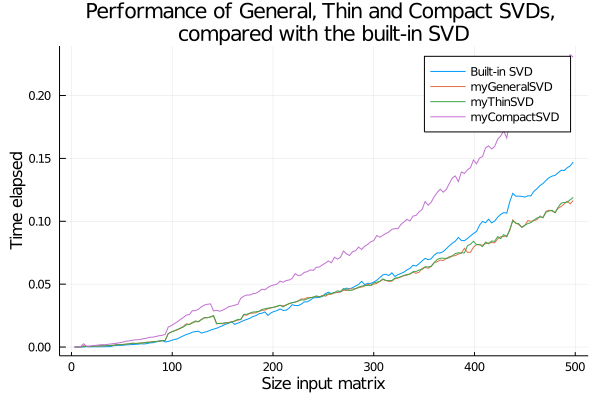

In [12]:
matrix_sizes = []
builtInSVD_speed = []
generalSVD_speed = []
thinSVD_speed = []
compactSVD_speed = []
for n in 3:3:max_size
    push!(matrix_sizes, n)
    t1 = 0
    t2 = 0
    t3 = 0
    t4 = 0
    for i in 1:10
        A = rand(n,n)
        t1 += @elapsed svd(A)
        t2 += @elapsed mySVD(A)
        t3 += @elapsed myThinSVD(A) 
        t4 += @elapsed myCompactSVD(A) 
    end
    push!(builtInSVD_speed, t1 / 10)
    push!(generalSVD_speed, t2 / 10)
    push!(thinSVD_speed, t3 / 10)
    push!(compactSVD_speed, t4 / 10)
end

plot(matrix_sizes, builtInSVD_speed, label="Built-in SVD") 
plot!(matrix_sizes, generalSVD_speed, label="myGeneralSVD") 
plot!(matrix_sizes, thinSVD_speed, label="myThinSVD") 
plot!(matrix_sizes, compactSVD_speed, label="myCompactSVD") 
xlabel!("Size input matrix")
ylabel!("Time elapsed")
title!("Performance of General, Thin and Compact SVDs, \ncompared with the built-in SVD")

#### Truncated SVD 
##### Compared with truncatedSVD algrorithm, which is implemented using svd algorithm from LinearAlgebra.jl, and with tsvd, from TSVD.jl

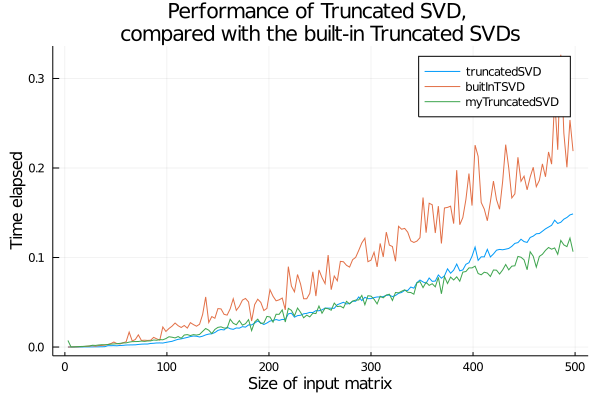

In [20]:
matrix_sizes = []
truncatedSVD_speed = []
builtInTSVD_speed = []
myTruncatedSVD_speed = []
for n in 3:3:max_size
    push!(matrix_sizes, n)
    t1 = 0
    t2 = 0
    t3 = 0
    for i in 1:10
        A = rand(n,n)
        t = rand(1:n)
        t1 += @elapsed truncatedSVD(A, t) 
        t2 += @elapsed tsvd(A, t)
        t3 += @elapsed myTruncatedSVD(A, t) 
    end
    push!(truncatedSVD_speed, t1 / 10)
    push!(builtInTSVD_speed, t2 / 10)
    push!(myTruncatedSVD_speed, t3 / 10)
end

plot(matrix_sizes, truncatedSVD_speed, label="truncatedSVD") 
plot!(matrix_sizes, builtInTSVD_speed, label="buitInTSVD") 
plot!(matrix_sizes, myTruncatedSVD_speed, label="myTruncatedSVD") 
xlabel!("Size of input matrix")
ylabel!("Time elapsed")
title!("Performance of Truncated SVD, \ncompared with the built-in Truncated SVDs")

### Previous Implementation

#### SVD algorithm 
Implemented from scratch

In [14]:
#=
# SVD algorithm
# Takes matrix A as input, outputs unitary matrices U, V and diagonal matrix S
# Such that A = U*S*V^T
# Optional input iterations
function SVD(A, error=1e-3)
    m = size(A, 1)
    n = size(A, 2)
    # Reduce A to a bidiagonal matrix
    A, d, e, tauq, taup = LAPACK.gebrd!(A)
    B = diagm(m, n, 0 => d, 1 => e)
    Q, P = AccumulateHouseholder(A, tauq, taup)
    # Compute the QR factorization of A implicitly
    R, S, C, iters, diags = implicitQR(B, error)    
    # U = R*Q is the accumulation of row Givens rotations and pre-multiplied Householder reflections
    # V = C*P is the accumulation of column Givens rotations and post-multiplied Householder reflections
    return R*Q, S, C*P, iters, diags
end
=#

#### Helper Procedures: WilkinsonShift, HouseholderToMatrix and AccumulateHouseholder

In [15]:
#=
# Computes the Wilkonson shift for a symmetric matrix A where submatrix A[n-1:n, n-1:n] = [a b, b c]
function WilkinsonShift(A)
    n = size(A, 1)
    a = A[n-1, n-1]
    b = A[n-1, n]
    c = A[n, n]
    delta = (a - c)/2
    return c - sign(delta)*b^2/(abs(delta) + sqrt(delta^2+b^2))
end

#Computes the Householder matrix from the unit vector v, scalar tau, and dimension n
function HouseholderToMatrix(v, tau, n)
    return Matrix{Float64}(I, n, n) .- tau*(v*v')
end

# Takes the output of gebrd! and reconstructs Q, P
function AccumulateHouseholder(A, tauq, taup)
    m = size(A, 1)
    n = size(A, 2)
    Q = I
    P = I
    # Loop over the input matrix and calculate H_i
    if m >= n
        for i in 1:m-1
            vq = zeros(m)
            vq[i] = 1
            vq[i+1:m] = A[i+1:m, i]
            Hq = HouseholderToMatrix(vq, tauq[i], m)
            Q = Q*Hq
        end
        for i in 1:n-2
            vp = zeros(n)
            vp[i+1] = 1
            vp[i+2:n] = A[i, i+2:n]
            Hp = HouseholderToMatrix(vp, taup[i], n)
            P = P*Hp
        end
    else
        for i in 1:m-2
            vq = zeros(m)
            vq[i+2] = 1
            vq[i+2:m] = A[i+2:m, i]
            Hq = HouseholderToMatrix(vq, tauq[i], m)
            Q = Q*Hq
        end
        for i in 1:n-1
            vp = zeros(n)
            vp[i] = 1
            vp[i+1:n] = A[i, i+1:n]
            Hp = HouseholderToMatrix(vp, taup[i], n)
            P = P*Hp
        end
    end
    return Q, P
end
=#

#### Implicit QR Algorithm
We didn't succeed in implementing it.

In [16]:
#=
# Implicit QR algorithm
# Takes bidiagonal matrix A and outputs the eigenvalues and rotations
# Optional input iterations
function implicitQR(A, error=1e-3)
    m = size(A, 1)
    n = size(A, 2)
    # Column rotations accumulation matrix
    C = Matrix{Float64}(I, n, n)
    # Row rotations accumulation matrix
    R = Matrix{Float64}(I, m, m)
    iter = 1000
    iters = [x for x in 1:iter]
    diags = []
    while (iter > 0) # A[1,2] > error)
        T = adjoint(A)*A
        mu = WilkinsonShift(T)
        # Determine the first Givens row rotation G1T that would be applied to T - mu*I
        G = givens(T-mu*I, 1, 2, 1)[1]
        # Apply to columns 1 & 2, creating an unwanted nonzero at (2, 1)
        A = A*G
        # Store G1 in C
        C = C*G
        # Determine Givens row rotation H1
        H = givens(A, 1, 2, 1)[1]
        # Apply to rows 1 & 2
        A = H*A
        # Store H1 in R
        R = H*R
        # Keep rotating the nonzero entry down the diagonal until it is eliminated
        i = 2
        while (i < m && i < n)
            G = givens(A', i, i+1, i-1)[1]
            A = A*G'
            C = C*G'
            H = givens(A, i, i+1, i)[1]
            A = H*A
            R = H*R
            i += 1
        end
        iter -= 1
        push!(diags, abs(A[1,2]))
    end
    return R, A, C, iters, diags
end
=#